# Importing required python libraries

In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Downloading MNIST dataset

In [ ]:
batch_size_train = 64
batch_size_test = 1000

In [ ]:
training_data = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_data=torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [ ]:
train_loader = torch.utils.data.DataLoader(training_data
  ,
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data
  ,
  batch_size=batch_size_test, shuffle=True)

# Data Visualisation


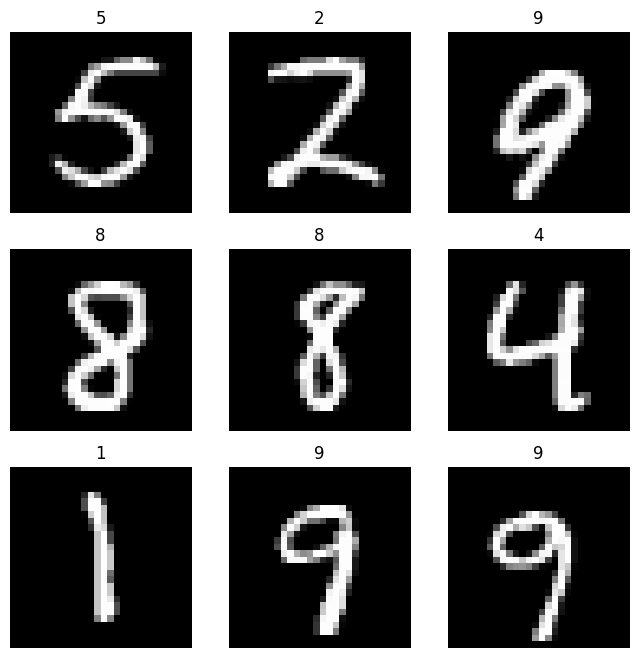

In [ ]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]

In [ ]:
img.shape

torch.Size([1, 28, 28])

# Defining Autoencoder Architecture

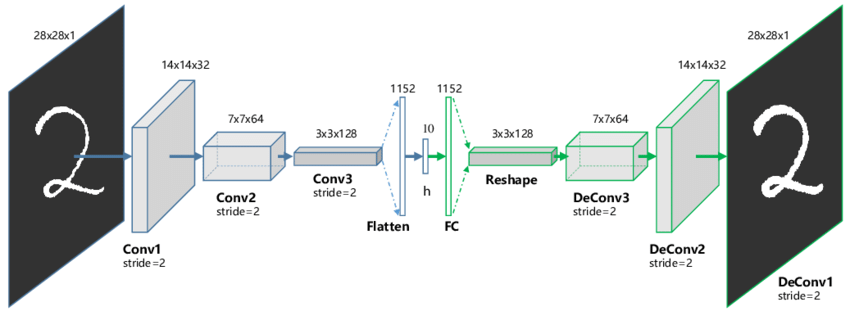

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        ## encoder layers ##

        self.conv1 = nn.Conv2d(1, 32, 3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2)
        #self.flatten = nn.Flatten()
        self.bottleneck=nn.Linear(3*3*128,10)
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(128, 64, 3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 32, 3, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(32, 1, 3, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        #x = self.flatten(x)
       # print(x.shape)
        x=x.view(x.size(0), 128, 3, 3)
       # x = x.view(-1, 3*3*128)

        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv3(x))
        return x
# initialize the NN
model = autoencoder()

In [ ]:
print(model)

autoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (bottleneck): Linear(in_features=1152, out_features=10, bias=True)
  (t_conv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2))
)


In [ ]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


autoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (bottleneck): Linear(in_features=1152, out_features=10, bias=True)
  (t_conv1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (t_conv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2))
)

In [ ]:
#Epochs
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

RuntimeError: ignored